# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a simple [linear regression model](https://scikit-learn.org/stable/modules/linear_model.html)
        - An advanced regressor of your choice (e.g., Random Forest, Neural Network, etc.)

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Assuming that the files `adult.data` and `adult.test` are in `../data/adult/`, then you can use the code below to load them.

In [1]:
import pandas as pd

# Reading the forestfires.csv file into a DataFrame named 'fires_dt'.
fires_dt = pd.read_csv('../../05_src/data/fires/forestfires.csv')

# Renaming the columns of the DataFrame to have more descriptive names.
fires_dt = fires_dt.rename(
    columns = {'X':'coord_x', 'Y':'coord_y', 'month': 'month', 'day':'day', 'FFMC': 'ffmc', 
               'DMC': 'dmc', 'DC':'dc', 'ISI': 'isi', 'temp': 'temp', 'RH': 'rh',
               'wind': 'wind', 'rain': 'rain', 'area': 'area'})

# Exploring the DataFrame to understand its structure and content.
print(fires_dt.info()) # It seems that there are no missing, we have 11 numerical features, and two cathegorical features
print(fires_dt.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB
None
          coord_x     coord_y        ffmc         dmc          dc         isi  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.021663   
std      2.313

# Get X and Y

Create the features data frame and target data.

In [2]:
# Identify the feature columns and the target column in the dataset 'fires_dt'.
features = fires_dt.columns[fires_dt.columns != 'area']
area = fires_dt.columns[fires_dt.columns == 'area']

# Create the features data frame 'X' by selecting the feature columns from 'fires_dt'.
X = fires_dt[features]

# Create the target data frame 'Y' by selecting the target column from 'fires_dt'.
Y= fires_dt[area]

# Print the shape of the features data frame 'X', 'Y'.
print('Features data frame: ', X.shape)
print('Target data frame: ', Y.shape)
X.columns

Features data frame:  (517, 12)
Target data frame:  (517, 1)


Index(['coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi',
       'temp', 'rh', 'wind', 'rain'],
      dtype='object')

In [3]:
# importing libraries
import os
import contextlib
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
import pickle
import shap
import warnings


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [4]:
# preproc1

# Identify numeric and categorical features in the dataset 'X'.
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define a pipeline for scaling numeric features using StandardScaler.
nums1 = Pipeline([ 
    ('scaler', StandardScaler(),) # Scale features using StandaScaler
])

# Define a pipeline for one-hot encoding categorical features using OneHotEncoder.
cat1 = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore')) # One-hot encode categorical features -OneHotEncoder
])

# Define a ColumnTransformer that applies different preprocessing steps to numeric and categorical features.
preproc1 = ColumnTransformer([
    ('num_trasnforms', nums1, numeric_features), # Apply num_transforms to numerical features
    ('cat_trasnforms', cat1, categorical_features) # Apply cat_transforms to categorical features
])

preproc1



ColumnTransformer(transformers=[('num_trasnforms',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 Index(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind',
       'rain'],
      dtype='object')),
                                ('cat_trasnforms',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['month', 'day'], dtype='object'))])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [5]:
# Pipeline for some  numeric variables using StandardScaler followed by PowerTransformer

# Define a pipeline for scaling numeric features using StandardScaler.
nums1 = Pipeline([
    ('scaler', StandardScaler())  # Step 1: Scale features using StandardScaler
])

# Define a pipeline for scaling numeric features using StandardScaler
# and then applying a PowerTransformer with the 'yeo-johnson' method.
nums2 = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Scale features using StandardScaler
    ('transform', PowerTransformer(method='yeo-johnson', standardize=False, copy=False))  # Step 2: Transform using Yeo-Johnson
])

# Define a pipeline for one-hot encoding categorical features.
cat2 = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Define a ColumnTransformer that applies different preprocessing steps to different subsets of features.
preproc2 = ColumnTransformer([
    ('num_transforms_nums2', nums1, ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi']),  # Apply nums2 to rest of the numeric variables
    ('num_transforms_nums1', nums2, ['temp', 'rh', 'wind', 'rain']),  # Apply nums1 to a subset of numeric variables
    ('cat_transforms', cat2, categorical_features)  # Apply cat2 to categorical features
])

preproc2

ColumnTransformer(transformers=[('num_transforms_nums2',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi']),
                                ('num_transforms_nums1',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('transform',
                                                  PowerTransformer(copy=False,
                                                                   standardize=False))]),
                                 ['temp', 'rh', 'wind', 'rain']),
                                ('cat_transforms',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['month', 'day'], dtype='object'))])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [6]:
# Pipeline A = preproc1 + baseline

# Define the pipeline with preprocessing and the RandomForestRegressor.
pipeline_a = Pipeline([
    ('preprocessing', preproc1),  # Preprocessing 1
    ('regressor', LinearRegression())  # LinearRegression as the regressor
])


# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Perform cross-validation on training data
cv_results = cross_validate(pipeline_a, X_train, Y_train, cv=5,
                            scoring=('neg_mean_squared_error', 'r2'),
                            return_train_score=True)

# Calculate the root mean squared error (RMSE) for the training and testing data from the cross-validation results.
train_rmse_cv = np.sqrt(-cv_results['train_neg_mean_squared_error'])
test_rmse_cv = np.sqrt(-cv_results['test_neg_mean_squared_error'])
mean_train_rmse = np.mean(train_rmse_cv)
mean_test_rmse = np.mean(test_rmse_cv)

# Extract R² scores for the training and testing data from the cross-validation results.
train_r2_cv = cv_results['train_r2']
test_r2_cv = cv_results['test_r2']
mean_train_r2 = np.mean(train_r2_cv)
mean_test_r2 = np.mean(test_r2_cv)

# Print cross-validation results
print("\nCross-validation results:")
print(f"Train RMSE: {train_rmse_cv}")
print(f"Mean Train RMSE: {mean_train_rmse:.3f}")
print(f"Test RMSE: {test_rmse_cv}")
print(f"Mean Test RMSE: {mean_test_rmse:.3f}")

print(f"\nTrain R^2: {train_r2_cv}")
print(f"Mean Train R^2: {mean_train_r2:.3f}")
print(f"Test R^2: {test_r2_cv}")
print(f"Mean Test R^2: {mean_test_r2:.3f}")

pipeline_a


Cross-validation results:
Train RMSE: [45.57465123 48.89302357 47.68924235 27.03532174 48.00669494]
Mean Train RMSE: 43.440
Test RMSE: [40.7767344  19.57811391 33.3675258  85.26917909 26.89522755]
Mean Test RMSE: 41.177

Train R^2: [0.05253757 0.05984555 0.06080771 0.08034482 0.0573024 ]
Mean Train R^2: 0.062
Test R^2: [-0.01926665 -0.77182861 -0.54567613 -0.009167   -0.2320665 ]
Mean Test R^2: -0.316


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_trasnforms',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind',
       'rain'],
      dtype='object')),
                                                 ('cat_trasnforms',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['month', 'day'], dtype='object'))])),
                ('regressor', LinearRegression())])

In [7]:
# Pipeline B = preproc2 + baseline

# Define the pipeline with preprocessing and the RandomForestRegressor.
pipeline_b = Pipeline([
    ('preprocessing', preproc2),  # Preprocessing 2
    ('regressor', LinearRegression())  # LinearRegression as the regressor
])

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Perform cross-validation on training data
cv_results = cross_validate(pipeline_b, X_train, Y_train, cv=5,
                            scoring=('neg_mean_squared_error', 'r2'),
                            return_train_score=True)

# Calculate the root mean squared error (RMSE) for the training and testing data from the cross-validation results.
train_rmse_cv = np.sqrt(-cv_results['train_neg_mean_squared_error'])
test_rmse_cv = np.sqrt(-cv_results['test_neg_mean_squared_error'])
mean_train_rmse = np.mean(train_rmse_cv)
mean_test_rmse = np.mean(test_rmse_cv)

# Extract R² scores for the training and testing data from the cross-validation results.
train_r2_cv = cv_results['train_r2']
test_r2_cv = cv_results['test_r2']
mean_train_r2 = np.mean(train_r2_cv)
mean_test_r2 = np.mean(test_r2_cv)

# Print cross-validation results
print("\nCross-validation results:")
print(f"Train RMSE: {train_rmse_cv}")
print(f"Mean Train RMSE: {mean_train_rmse:.3f}")
print(f"Test RMSE: {test_rmse_cv}")
print(f"Mean Test RMSE: {mean_test_rmse:.3f}")

print(f"\nTrain R^2: {train_r2_cv}")
print(f"Mean Train R^2: {mean_train_r2:.3f}")
print(f"Test R^2: {test_r2_cv}")
print(f"Mean Test R^2: {mean_test_r2:.3f}")

pipeline_b


Cross-validation results:
Train RMSE: [45.5381889  48.85974252 47.67841297 27.01516117 47.97539779]
Mean Train RMSE: 43.413
Test RMSE: [40.90572875 19.58611857 29.13779222 85.22354215 26.8701151 ]
Mean Test RMSE: 40.345

Train R^2: [0.05405301 0.06112503 0.06123421 0.0817159  0.05853115]
Mean Train R^2: 0.063
Test R^2: [-0.02572561 -0.77327776 -0.17864705 -0.00808705 -0.22976678]
Mean Test R^2: -0.243


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms_nums2',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi']),
                                                 ('num_transforms_nums1',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('transform',
                                                                   PowerTransformer(copy=False,
                                                                                    standardize=False))]),
                                                  ['temp', 'rh', 'wind',
                                                   'rain']),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['month', 'day'], dtype='object'))])),
                ('regressor', LinearRegression())])

In [8]:
# Pipeline C = preproc1 + advanced model

# Define the pipeline with preprocessing and the RandomForestRegressor.
pipeline_c = Pipeline([
    ('preprocessing', preproc1),  # Preprocessing steps
    ('regressor', RandomForestRegressor())  # RandomForestRegressor as the regressor
])

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Perform cross-validation on training data
cv_results = cross_validate(pipeline_c, X_train, Y_train, cv=5,
                            scoring=('neg_mean_squared_error', 'r2'),
                            return_train_score=True)

# Calculate the root mean squared error (RMSE) for the training and testing data from the cross-validation results.
train_rmse_cv = np.sqrt(-cv_results['train_neg_mean_squared_error'])
test_rmse_cv = np.sqrt(-cv_results['test_neg_mean_squared_error'])
mean_train_rmse = np.mean(train_rmse_cv)
mean_test_rmse = np.mean(test_rmse_cv)

# Extract R² scores for the training and testing data from the cross-validation results.
train_r2_cv = cv_results['train_r2']
test_r2_cv = cv_results['test_r2']
mean_train_r2 = np.mean(train_r2_cv)
mean_test_r2 = np.mean(test_r2_cv)

# Print cross-validation results
print("\nCross-validation results:")
print(f"Train RMSE: {train_rmse_cv}")
print(f"Mean Train RMSE: {mean_train_rmse:.3f}")
print(f"Test RMSE: {test_rmse_cv}")
print(f"Mean Test RMSE: {mean_test_rmse:.3f}")

print(f"\nTrain R^2: {train_r2_cv}")
print(f"Mean Train R^2: {mean_train_r2:.3f}")
print(f"Test R^2: {test_r2_cv}")
print(f"Mean Test R^2: {mean_test_r2:.3f}")

pipeline_c

c:\Users\skiev\AppData\Local\Continuum\envs\scale2prod\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\skiev\AppData\Local\Continuum\envs\scale2prod\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\skiev\AppData\Local\Continuum\envs\scale2prod\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\skiev\AppData\Local\Continuum\envs\scale2prod\Lib\site-packages\sklearn\base.py:1473: DataConvers


Cross-validation results:
Train RMSE: [19.7698106  20.68920589 20.79195147 12.3455212  23.12945457]
Mean Train RMSE: 19.345
Test RMSE: [56.27322506 44.61884633 30.30009506 86.80016732 29.16838541]
Mean Test RMSE: 49.432

Train R^2: [0.82171274 0.83165778 0.82147289 0.80822994 0.78117367]
Mean Train R^2: 0.813
Test R^2: [-0.94118328 -8.20273005 -0.27455468 -0.04573104 -0.44913379]
Mean Test R^2: -1.983


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_trasnforms',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind',
       'rain'],
      dtype='object')),
                                                 ('cat_trasnforms',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['month', 'day'], dtype='object'))])),
                ('regressor', RandomForestRegressor())])

In [9]:
# Pipeline D = preproc2 + advanced model

# Define the pipeline with preprocessing and the RandomForestRegressor.
pipeline_d = Pipeline([
    ('preprocessing', preproc2),  # Preprocessing steps
    ('regressor', RandomForestRegressor())  # RandomForestRegressor as the regressor
])


# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Perform cross-validation on training data
cv_results = cross_validate(pipeline_d, X_train, Y_train, cv=5,
                            scoring=('neg_mean_squared_error', 'r2'),
                            return_train_score=True)

# Calculate the root mean squared error (RMSE) for the training and testing data from the cross-validation results.
train_rmse_cv = np.sqrt(-cv_results['train_neg_mean_squared_error'])
test_rmse_cv = np.sqrt(-cv_results['test_neg_mean_squared_error'])
mean_train_rmse = np.mean(train_rmse_cv)
mean_test_rmse = np.mean(test_rmse_cv)

# Extract R² scores for the training and testing data from the cross-validation results.
train_r2_cv = cv_results['train_r2']
test_r2_cv = cv_results['test_r2']
mean_train_r2 = np.mean(train_r2_cv)
mean_test_r2 = np.mean(test_r2_cv)

# Print cross-validation results
print("\nCross-validation results:")
print(f"Train RMSE: {train_rmse_cv}")
print(f"Mean Train RMSE: {mean_train_rmse:.3f}")
print(f"Test RMSE: {test_rmse_cv}")
print(f"Mean Test RMSE: {mean_test_rmse:.3f}")

print(f"\nTrain R^2: {train_r2_cv}")
print(f"Mean Train R^2: {mean_train_r2:.3f}")
print(f"Test R^2: {test_r2_cv}")
print(f"Mean Test R^2: {mean_test_r2:.3f}")

pipeline_d

c:\Users\skiev\AppData\Local\Continuum\envs\scale2prod\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\skiev\AppData\Local\Continuum\envs\scale2prod\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\skiev\AppData\Local\Continuum\envs\scale2prod\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\skiev\AppData\Local\Continuum\envs\scale2prod\Lib\site-packages\sklearn\base.py:1473: DataConvers


Cross-validation results:
Train RMSE: [17.87679362 19.90679855 22.04560387 11.382541   21.37557696]
Mean Train RMSE: 18.517
Test RMSE: [58.40206614 41.30746971 29.76412758 87.14764189 27.58873228]
Mean Test RMSE: 48.842

Train R^2: [0.85422114 0.84414948 0.79929524 0.83698019 0.81310208]
Mean Train R^2: 0.830
Test R^2: [-1.09083304 -6.88746046 -0.22986319 -0.05412025 -0.29642439]
Mean Test R^2: -1.712


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms_nums2',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi']),
                                                 ('num_transforms_nums1',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('transform',
                                                                   PowerTransformer(copy=False,
                                                                                    standardize=False))]),
                                                  ['temp', 'rh', 'wind',
                                                   'rain']),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['month', 'day'], dtype='object'))])),
                ('regressor', RandomForestRegressor())])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [10]:
# Tunning pipeline_a

# Define the parameter grid for the GridSearchCV to tune the RandomForestRegressor.
param_grid_a = {
    'regressor__fit_intercept': [True, False],  # Whether to calculate the intercept
    'preprocessing__num_trasnforms__scaler__with_mean': [True, False],  # Centering the data
    'preprocessing__num_trasnforms__scaler__with_std': [True, False],   # Scaling to unit variance
}

#use gridsearch to test all values for n_neighbors
pipe_gs_a = GridSearchCV(pipeline_a, param_grid_a, cv=5, verbose=10)

# Suppress stdout output to avoid clutter during the fitting process.
with open(os.devnull, 'w') as devnull:
    with contextlib.redirect_stdout(devnull):
        pipe_gs_a.fit(X, Y)

# Print the best parameters and the best score found by the grid search.
print("Best parameters: ", pipe_gs_a.best_params_)
print("Best score: ", pipe_gs_a.best_score_)

Best parameters:  {'preprocessing__num_trasnforms__scaler__with_mean': False, 'preprocessing__num_trasnforms__scaler__with_std': False, 'regressor__fit_intercept': False}
Best score:  -4.617398519191055


In [11]:
# Tunning pipeline_b

# Define the parameter grid for the GridSearchCV to tune the RandomForestRegressor.
param_grid_b = {
    'regressor__fit_intercept': [True, False],  # Whether to calculate the intercept
    'preprocessing__num_transforms_nums2__scaler__with_mean': [True, False],  # Centering the data for num_transforms_nums2
    'preprocessing__num_transforms_nums2__scaler__with_std': [True, False],   # Scaling to unit variance for num_transforms_nums2
    'preprocessing__num_transforms_nums1__scaler__with_mean': [True, False],  # Centering the data for num_transforms_nums1
    'preprocessing__num_transforms_nums1__scaler__with_std': [True, False],    # Scaling to unit variance for num_transforms_nums1
    'preprocessing__num_transforms_nums1__transform__method': ['yeo-johnson', 'box-cox'],  # Method for PowerTransformer in num_transforms_nums1
}

# Initialize GridSearchCV with the pipeline and parameter grid.
pipe_gs_b = GridSearchCV(pipeline_b, param_grid_b, cv=5, verbose=10)

# Suppress stdout output to avoid clutter during the fitting process.
with open(os.devnull, 'w') as devnull:
    with contextlib.redirect_stdout(devnull):
        pipe_gs_b.fit(X, Y)

# Print the best parameters and the best score found by the grid search.
print("Best parameters: ", pipe_gs_b.best_params_)
print("Best score: ", pipe_gs_b.best_score_)

Best parameters:  {'preprocessing__num_transforms_nums1__scaler__with_mean': True, 'preprocessing__num_transforms_nums1__scaler__with_std': True, 'preprocessing__num_transforms_nums1__transform__method': 'yeo-johnson', 'preprocessing__num_transforms_nums2__scaler__with_mean': False, 'preprocessing__num_transforms_nums2__scaler__with_std': False, 'regressor__fit_intercept': False}
Best score:  -4.571365688119412


c:\Users\skiev\AppData\Local\Continuum\envs\scale2prod\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
160 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\skiev\AppData\Local\Continuum\envs\scale2prod\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\skiev\AppData\Local\Continuum\envs\scale2prod\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\skiev\App

In [12]:
# Tunning pipeline_c 

# Define the parameter grid for the GridSearchCV to tune the RandomForestRegressor.
param_grid_c = {
    'regressor__n_estimators': [50, 100, 200],          # Number of trees in the forest
    'regressor__max_features': ['auto', 'sqrt', 'log2'], # Number of features to consider at every split
    'regressor__max_depth': [None, 10, 20, 30],          # Maximum number of levels in tree
    'regressor__min_samples_split': [2, 5, 10],          # Minimum number of samples required to split a node
    'regressor__min_samples_leaf': [1, 2, 4],            # Minimum number of samples required at each leaf node
    'regressor__bootstrap': [True, False]                # Method of selecting samples for training each tree
}
# Initialize GridSearchCV with the pipeline and parameter grid.
pipe_gs_c = GridSearchCV(pipeline_c, param_grid_c, cv=5, verbose=10)

# Suppress stdout output to avoid clutter during the fitting process.
with open(os.devnull, 'w') as devnull:
    with contextlib.redirect_stdout(devnull):
        pipe_gs_c.fit(X, Y)

# Print the best parameters and the best score found by the grid search.
print("Best parameters: ", pipe_gs_c.best_params_)
print("Best score: ", pipe_gs_c.best_score_)

c:\Users\skiev\AppData\Local\Continuum\envs\scale2prod\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\skiev\AppData\Local\Continuum\envs\scale2prod\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\skiev\AppData\Local\Continuum\envs\scale2prod\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\skiev\AppData\Local\Continuum\envs\scale2prod\Lib\site-packages\sklearn\base.py:1473: DataConvers

Best parameters:  {'regressor__bootstrap': True, 'regressor__max_depth': None, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 100}
Best score:  -2.1822909259985335


In [14]:
# Tunning pipeline_d
# Define the parameter grid for the GridSearchCV to tune the RandomForestRegressor.
param_grid_d = {
    'regressor__n_estimators': [50, 100, 200],          # Number of trees in the forest
    'regressor__max_features': ['auto', 'sqrt', 'log2'], # Number of features to consider at every split
    'regressor__max_depth': [None, 10, 20, 30],          # Maximum number of levels in tree
    'regressor__min_samples_split': [2, 5, 10],          # Minimum number of samples required to split a node
    'regressor__min_samples_leaf': [1, 2, 4],            # Minimum number of samples required at each leaf node
    'regressor__bootstrap': [True, False]                # Method of selecting samples for training each tree
}
# Initialize GridSearchCV with the pipeline and parameter grid.
pipe_gs_d = GridSearchCV(pipeline_d, param_grid_d, cv=5, verbose=10)

# Suppress stdout output to avoid clutter during the fitting process.
with open(os.devnull, 'w') as devnull:
    with contextlib.redirect_stdout(devnull):
        pipe_gs_d.fit(X_train, Y_train)

# Print the best parameters and the best score found by the grid search.
print("Best parameters: ", pipe_gs_d.best_params_)
print("Best score: ", pipe_gs_d.best_score_)

c:\Users\skiev\AppData\Local\Continuum\envs\scale2prod\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\skiev\AppData\Local\Continuum\envs\scale2prod\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\skiev\AppData\Local\Continuum\envs\scale2prod\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\skiev\AppData\Local\Continuum\envs\scale2prod\Lib\site-packages\sklearn\base.py:1473: DataConvers

Best parameters:  {'regressor__bootstrap': True, 'regressor__max_depth': 30, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 50}
Best score:  -0.14661973076622375


c:\Users\skiev\AppData\Local\Continuum\envs\scale2prod\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\skiev\AppData\Local\Continuum\envs\scale2prod\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\skiev\AppData\Local\Continuum\envs\scale2prod\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\skiev\

# Evaluate

+ Which model has the best performance?

Based on the best scores provided for each pipeline, pipeline_d has the best performance.

Here are the best scores for each pipeline:

- pipeline_a: Best score: -4.617398519191055
- pipeline_b: Best score: -4.571365688119412
- pipeline_c: Best score: -2.1822909259985335
- pipeline_d: Best score: -0.14661973076622375

Summary of Best Performing Model

- Best Parameters:

- regressor__bootstrap: True
- regressor__max_depth: 30
- regressor__max_features: 'log2'
- regressor__min_samples_leaf: 4
- regressor__min_samples_split: 10
- regressor__n_estimators: 50

Best Score: -0.14661973076622375

# Export

+ Save the best performing model to a pickle file.

In [15]:
# Define the filename for saving the pipeline object.
pipeline_D_file = 'pipeline_D.pkl'

# Save the pipeline object to the file using pickle.
with open(pipeline_D_file, 'wb') as file:
    pickle.dump(pipeline_D_file, file)


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [17]:
import shap

# Transform the test data using the preprocessing steps from the best estimator pipeline.
# 'pipe_gs_d.best_estimator_' refers to the best pipeline found by GridSearchCV.
# 'named_steps['preprocessing']' accesses the preprocessing steps in the pipeline.
# 'transform(X_test)' applies these preprocessing steps to the test data.
data_transform = pipe_gs_d.best_estimator_.named_steps['preprocessing'].transform(X_test)

# Create a SHAP explainer object for the tree-based model (e.g., RandomForestRegressor).
# 'pipe_gs_d.best_estimator_.named_steps['regressor']' accesses the regressor (model) in the pipeline.
# 'data_transform' provides the preprocessed test data to the explainer.
# 'feature_names' specifies the names of the features after preprocessing.
explainer = shap.explainers.Tree(
    pipe_gs_d.best_estimator_.named_steps['regressor'], 
    data_transform,
    feature_names = pipe_gs_d.best_estimator_.named_steps['preprocessing'].get_feature_names_out())

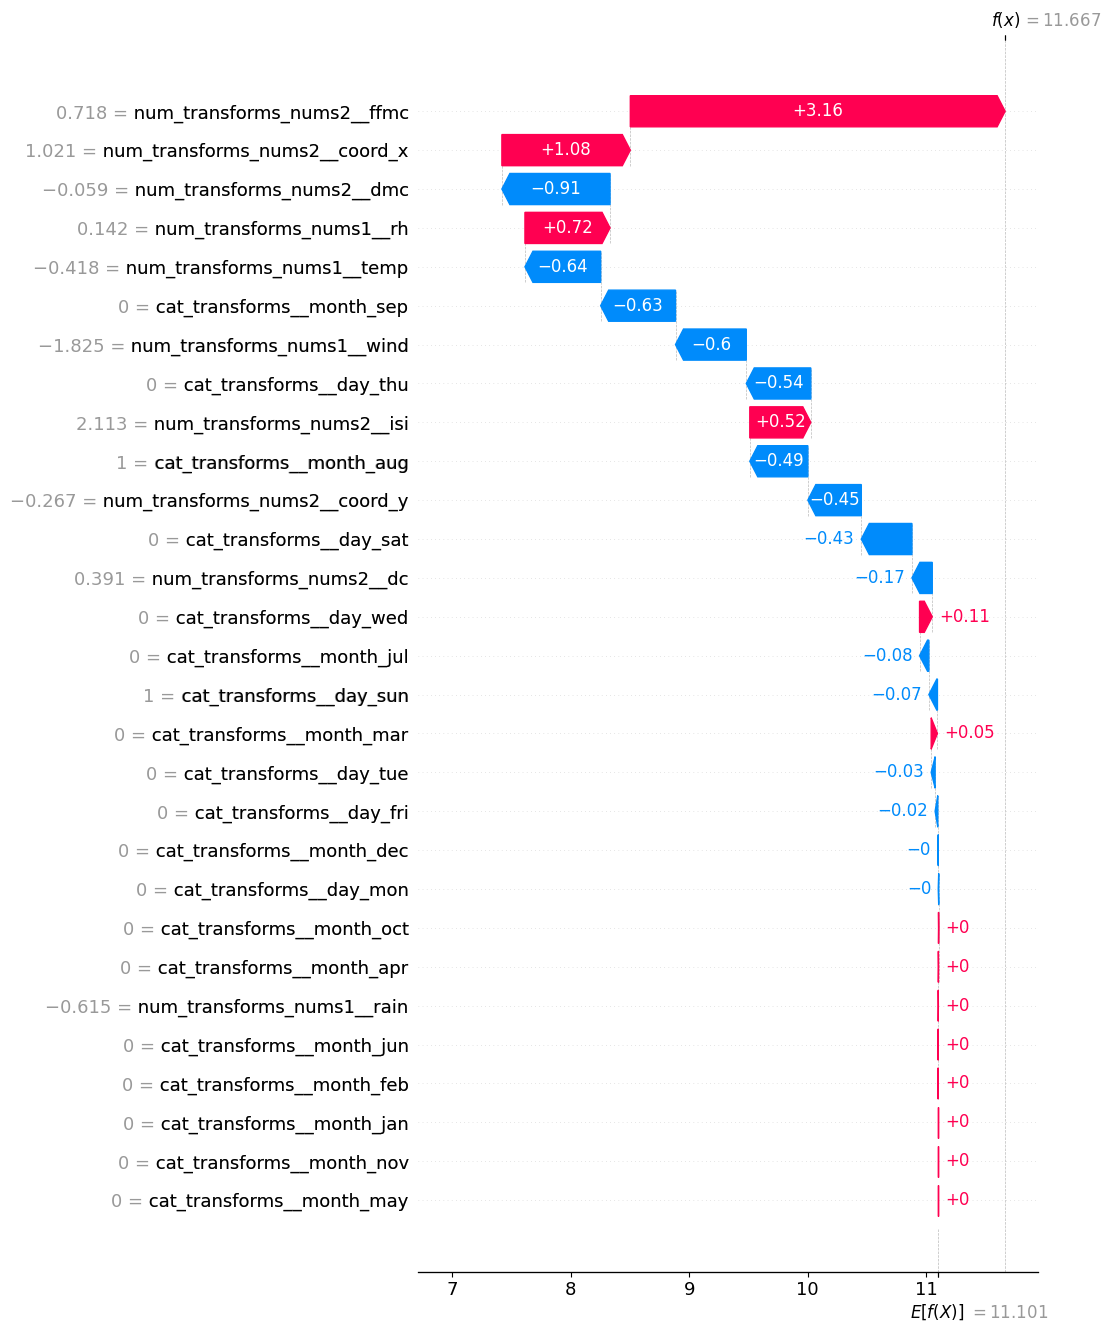

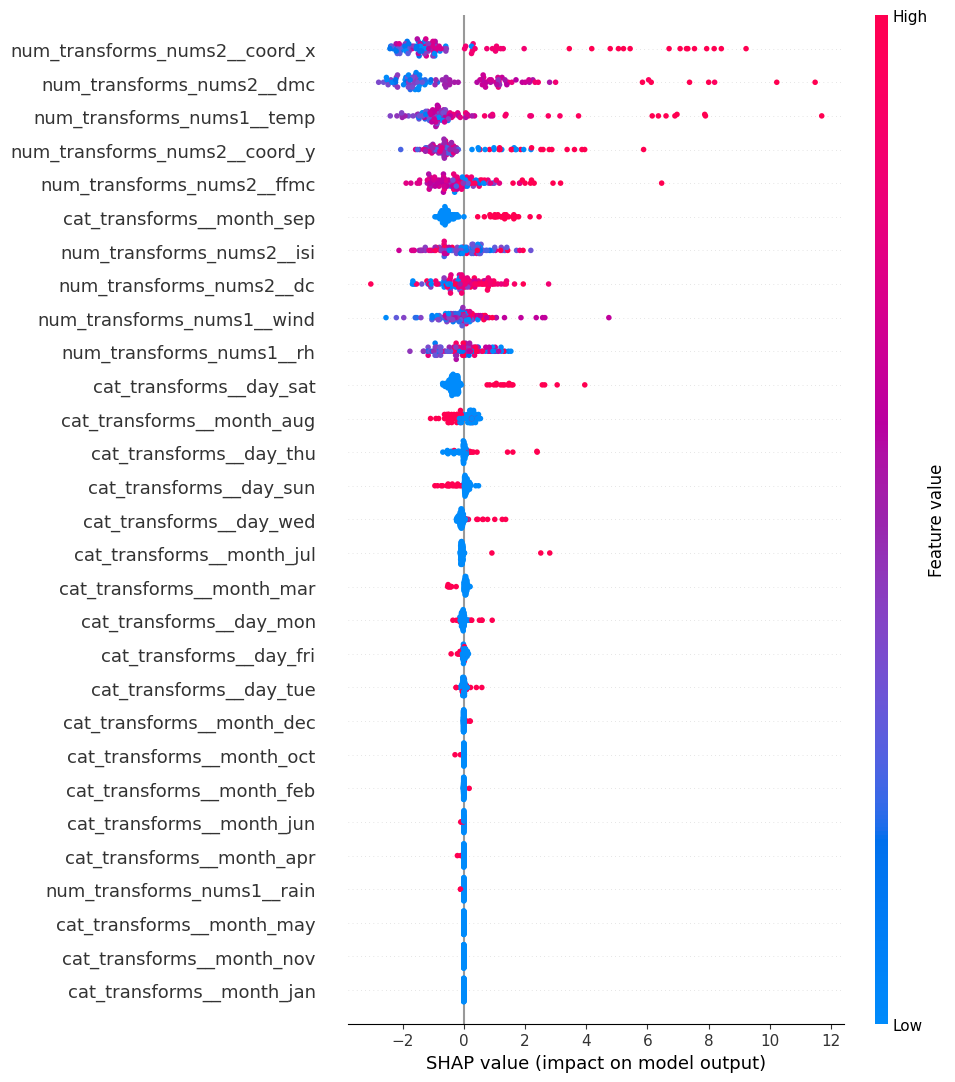

In [18]:
shap_values = explainer(data_transform, check_additivity = False)
shap.plots.waterfall(shap_values[42], max_display = 30)
shap.plots.beeswarm(shap_values, max_display = 30)

*(Answer here.)*

Most Important Features:

- FFMC (Fine Fuel Moisture Code)
- Temperature
- DMC (Duff Moisture Code)
- Coordinates
- Day of the week, particularly Saturday

Least Important Features:

- Months of January, November, May, and April
- Rain

Based on the results, the most important features are FFMC (Fine Fuel Moisture Code), temperature, DMC (Duff Moisture Code), coordinates, and the day of the week, particularly Saturday.

The least important features, as observed in the figures, include the months of January, November, May, and April, as well as the feature 'rain'.

To visualize the impact of these features, we could compare performance metrics (e.g., RMSE) when using all features versus using only the selected important features.

I recommend removing the month and rain features because they do not seem to enhance the model's performance.


## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.